# Data exploration
In this notebook we are going to study the data that will be use to develop benchmarking tools for binary classification algorithms. 

The data was developed for the [LHC Olympics 2020](https://lhco2020.github.io/homepage/). They published four different dataset of multijets events with the possibility of Beyond the Standar Model (BSM) physics. The data used for the project consist of the [R&D dataset](https://zenodo.org/record/2629073#.XKdewGXlRg0) and the dataset and masterkey for the [Black Box 1](https://zenodo.org/record/4536624)(BB1).

## The data

Both the R&D and BB1 datasets have data for the same event but are generated with a slightly different configuration on the Monte Carlo simulation:

The datasets consists on events from quantum chromodynamic (QCD), our background, and events of the type $Z'\rightarrow XY$ with $X\rightarrow q\bar{q}$ and $Y\rightarrow q\bar{q}$, our signal. The masses for the BSM particles on the R&D dataset are *Z'*, *X* and *Y* ara 3.5 TeV, 500 GeV and 100 GeV, respectively. The Feynman diagram is as follow:

![Feynman diagram for signals of R&D dataset and Black Box 1](https://i.imgur.com/7IKoJQi.png)

For the R&D dataset there are 1M background events and 100.000 signal events.

The BB1 dataset has 834 signal events from the total 1M events.

### .h5 files
Each row of the file is an event with:
- at least one anti-kT jet with R=1.0
- pseudorapidity $|\eta|<2,5$ 
- and transverse momentum $pT> 1,2$ TeV. 

For each event there is a list of all the hadrons as follow:

|Evento|$pT$ | $\eta$ | $\phi$ | $pT$ | $\eta$ | $\phi$ | $\cdots$ | signal |
|------|-----|--------|--------|------|--------|--------|--------|--------|
| 1    | $\cdots$| $\cdots$| $\cdots$| $\cdots$| $\cdots$| $\cdots$| $\cdots$| 1.0|
| 2    | $\cdots$| $\cdots$| $\cdots$| $\cdots$| $\cdots$| $\cdots$| $\cdots$| 0.0|
| $\vdots$| $\cdots$| $\cdots$| $\cdots$| $\cdots$| $\cdots$| $\cdots$| $\cdots$| 0.0|

The last column is the information about background (0) or signal (1). The events are zero-padded up to 700 hadrons.

For more information about the data visit the [LHC Olympics 2020 website](https://lhco2020.github.io/homepage/)

## R&D dataset

This dataset is mainly to setup and train the algorithms:

In [1]:
# Importing the main libraries
import pandas as pd
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Depending on the memory of the computer, 
# you'll be able to read more or less data
df = pd.read_hdf("../../events_anomalydetection.h5", stop=100000)

We know that for this dataset the percentage of signal is $100.000/1.100.000 = 9.09 \%$. Let's check the percentage for the data that was read on the cell above:

In [3]:
# Last column = 1 is signal
dfsig = df[df.iloc[:,-1]==1]    

ratio_sig = dfsig.shape[0]/df.shape[0]

print('The percentage of signal is {:.2%}'.format(ratio_sig))

The percentage of signal is 9.06%


We have a good representation of signal to continue with the analysis.

### Raw data
The data is as explained before:

In [4]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100
0,0.324101,-0.361158,2.737669,0.409859,-2.429939,0.729830,0.867922,-2.267777,-1.161310,0.383031,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.646304,-0.539460,-1.386258,0.471293,-1.636572,0.751657,0.453769,-1.099593,-0.393405,0.485929,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.325172,-0.833948,2.404844,1.295058,-2.089618,-1.873342,0.451272,-0.101877,2.217348,0.461293,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.290918,-2.200063,1.630132,0.565028,-1.714345,-2.617103,0.951042,-0.532720,2.941473,0.896248,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.526330,-2.349110,-1.745532,0.542491,-2.080352,-3.044045,0.390727,-1.278563,-2.131058,2.530358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


The events shouldn't have the same amount of hadrons:

In [5]:
# Eliminating the signal to avoid counting it as hadrons
ns_df = df.iloc[:,:-1]  

# We count the values of pT that are not zero
df['n_hadrons'] = ns_df.iloc[:,::3].gt(0).sum(axis='columns')
    
for event in range(5):
    print("Number of hadrons in event {}: {}".format(event, df.loc[event,'n_hadrons']))

Number of hadrons in event 0: 109
Number of hadrons in event 1: 208
Number of hadrons in event 2: 196
Number of hadrons in event 3: 183
Number of hadrons in event 4: 169


By plotting distributions we can get a better idea of the data. 

Starting by plotting the distribution of the number of hadron separating signal from background. For that we will be using functions on the <code>plotools</code> module on the <code>benchtools</code> package.

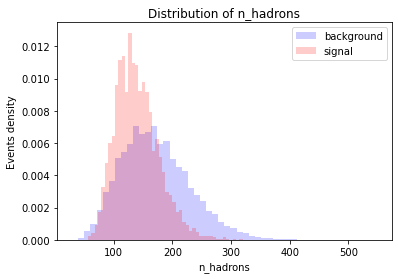

In [6]:
from benchtools.src.plotools import bkg_sig_hist

bkg_sig_hist(df, variable='n_hadrons', label=2100) # label=2100 because that's the column for signal or background
plt.show()

We see that the number of hadrons for background events is more broad with a lower peak around 150 hadrons. However, for the signal we have a narrower peak closer to 100 hadrons, meaning that signal events tends to have less hadrons.

Let's separate $pT$, $\eta$ and $\phi$ in their own dataframes, so we can plot the distributions:

In [7]:
# Each 3 values is pT, each 3 starting from 1 is eta, each 3 starting from 2 is phi
# And replacing the zeros with NaN so we can calculate the mean with .mean()

pt_df = ns_df.iloc[:,::3].replace(0, np.NaN)
eta_df = ns_df.iloc[:,1::3].replace(0, np.NaN)
phi_df = ns_df.iloc[:,2::3].replace(0, np.NaN)

# Calculating the mean value for each
df['mean_pT'] = pt_df.mean(axis=1)
df['mean_eta']= eta_df.mean(axis=1)
df['mean_phi']= phi_df.mean(axis=1)


Plotting this values:

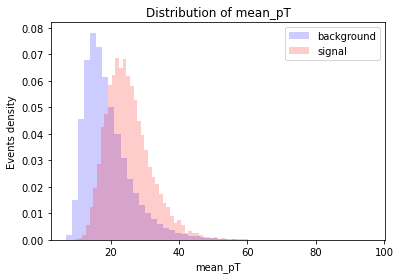

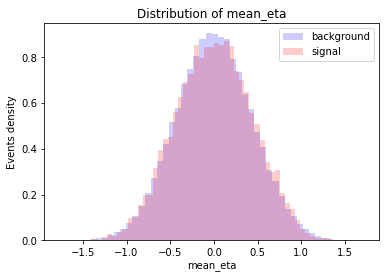

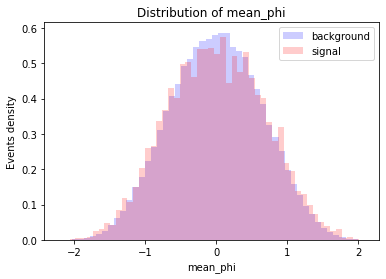

In [8]:
for variable in ['mean_pT', 'mean_eta', 'mean_phi']:
    bkg_sig_hist(df, variable, label=2100)
    plt.show()

We found **a difference between the mean value of pT for background and signal**. For phi and eta the data is distributed normally for both the signal and the background.

Maybe the distribution for the more energetic hadron tell us something:

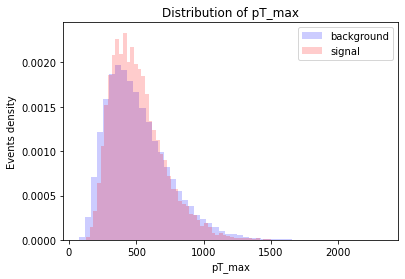

In [9]:
df['pT_max'] = pt_df.max(axis=1)

bkg_sig_hist(df, variable='pT_max', label=2100)
plt.show()

There are some differences: the peak for the signal is higher, but let's see if we can get more information by clustering the jets.
### Clustered data
For clustering the events we are using <code>pyjet</code>. 

I'll use functions from <code>benchtools.src.clustering</code> to get some important features about the events as: $pT$, *mass*, $\eta$, $\phi$, *energy*, *subjettiness* ($\tau_{21}$) and *number of constituyents* for the two principal jets, their *angular distance* ($\delta R$), the *invariant mass*($m_{jj}$), the *number of hadrons for the event* and the *label*.

First, I'm gonna use <code>build_features</code> to iterate over the file to generate the features:

In [10]:
from benchtools.src.clustering import build_features
build_features("../../events_anomalydetection.h5", 3, "data_exploration_RD")

Part 1/3


100%|██████████| 51200/51200 [12:52<00:00, 66.28it/s]


Part 2/3


100%|██████████| 51200/51200 [11:12<00:00, 76.09it/s]


Part 3/3


100%|██████████| 51200/51200 [11:02<00:00, 77.29it/s]


Done


Using <code>read_multifiles</code> we get the files as one dataframe:

In [11]:
from benchtools.src.datatools import read_multifiles
df = read_multifiles("data_exploration_RD", 3)
df.head()

,pT_j1,m_j1,eta_j1,phi_j1,E_j1,tau_21_j1,nhadrons_j1,pT_j2,m_j2,eta_j2,phi_j2,E_j2,tau_21_j2,nhadrons_j2,m_jj,deltaR_j12,n_hadrons,label
0,1286.727685,106.912129,0.185508,-2.763676,1313.290435,0.624659,36,1283.220733,63.164215,0.064989,0.393688,1287.481934,0.713248,33,2580.489568,3.159663,109.0,0.0
1,1354.394070,614.269108,0.826505,1.365524,1943.559886,0.311688,84,1325.613761,439.064150,-0.874319,-1.786248,1916.370744,0.276881,97,3859.315047,3.581406,208.0,0.0
2,1214.955723,645.865619,-0.196786,2.040545,1396.840654,0.238205,119,1072.462085,113.768840,0.143831,-1.090330,1089.530630,0.726963,59,2480.769725,3.149348,196.0,0.0
3,1285.227873,516.835248,0.328693,2.975321,1450.485926,0.013429,65,1220.251279,174.796077,0.294854,-0.322661,1285.618789,0.706361,89,2609.893413,3.298155,183.0,0.0
4,1210.415787,129.499352,-0.744836,-2.883347,1567.345300,0.423550,54,1091.785816,155.362262,1.060534,0.264977,1772.340209,0.787662,57,3313.488835,3.629229,169.0,1.0


### Distributions
We can graph the distribution of the variables to see if there is a difference for the background and the signal:

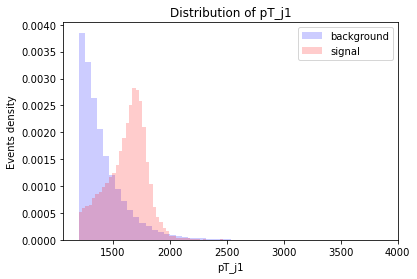

In [12]:
# Starting with the transversal momentum for the most energetic jet (or jet 1) of each event
bkg_sig_hist(df, variable='pT_j1', label='label')
plt.show()

We see that the transversal momentum *pT* for background events decays smoothly, indicating that the most energetic jets from these events tends to have *pT* lower than 1500 GeV. For signal events the most energetic jets haver larger *pT*, between 1500 and 2000 GeV.

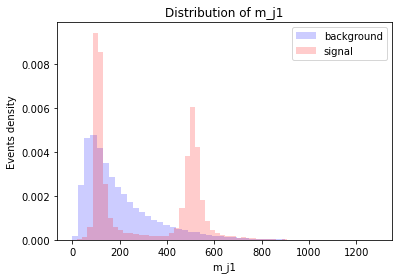

In [13]:
# The mass of jet 1
bkg_sig_hist(df, variable='m_j1', label='label')
plt.show()

Again, for background events the distribution of mass decays, bein most of the jets less massive. However, for the signal events we see two peaks: at 100 and 500 GeV. These are the masses of the *X* and *Y* particles for the event $Z'\rightarrow XY$

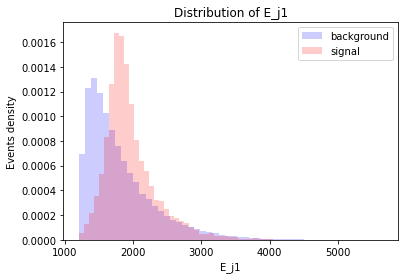

In [14]:
# The energy of jet 1
bkg_sig_hist(df, variable='E_j1', label='label')
plt.show()

Again, the background decays smoothly and most of the jets have lower energies. For the jets on the signal we see a peak at around 2000 GeV, with a different shape, indicating that jets of the signal tend to have higher energies than those of the background.

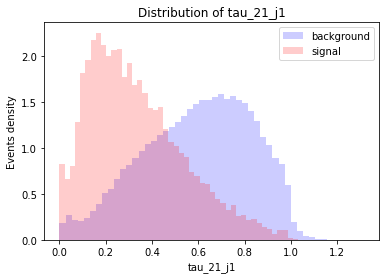

In [15]:
# The subjettiness variable of jet 1
bkg_sig_hist(df, variable='tau_21_j1', label='label')
plt.show()

We also see a different distribution for these variables. According to the definition of subjettiness we are looking for the probability of having subjets. This variable is lower when the jets have two subjets in it. Hence, the signal is grouped towards smaller values than the background, meaning that the jets of the signal are more consistent with having two jets.

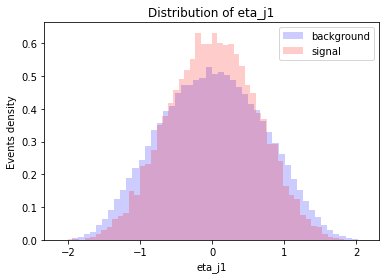

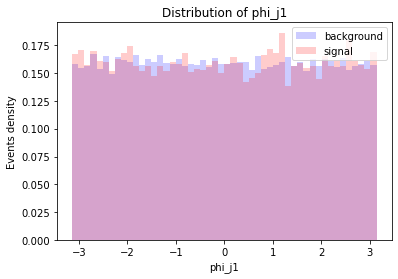

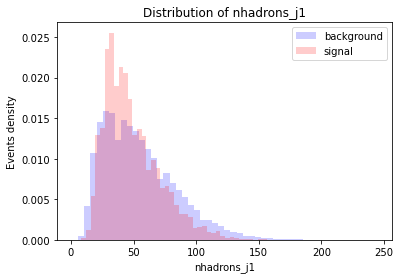

In [16]:
# Graphing eta and phi
for variable in ['eta_j1', 'phi_j1', 'nhadrons_j1']:
    bkg_sig_hist(df, variable=variable, label='label')

For $\eta$ we see that is more central on the signal events. The number of hadrons are narrower for the signal. On the variable $\phi$ there is not a marked difference between signal and background.
 
 Now, for the relation between the two most energetic jets of each event:

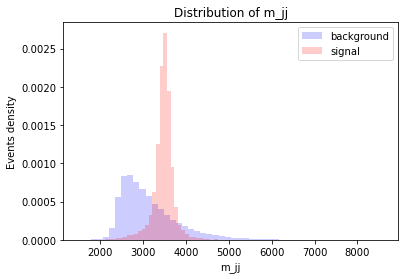

In [17]:
# The invariant mass
bkg_sig_hist(df, variable='m_jj', label='label')
plt.show()

The invariant mass also decays for background events. However, for the signal events we see a narrow peak at 3500 GeV which is the mass for *Z* in $Z'\rightarrow XY$

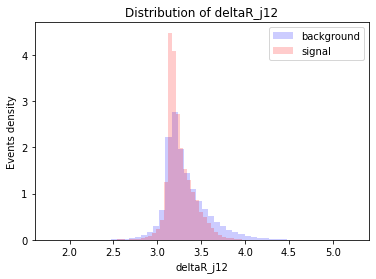

In [18]:
# The distance between jets
bkg_sig_hist(df, variable='deltaR_j12', label='label')
plt.show()

The signal distribution has a narrower and higher peak. However, the distributions are similar.

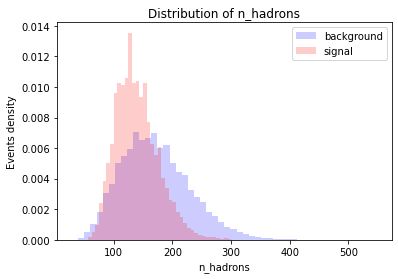

In [19]:
# And the number of hadrons for the events
bkg_sig_hist(df, variable='n_hadrons', label='label')
plt.show()

Here we see that the number of hadrons for signal events tends to be lower than for background events. Also, for signal the distribution is narrower.

## Correlations
We want to see how the variables relate to each other

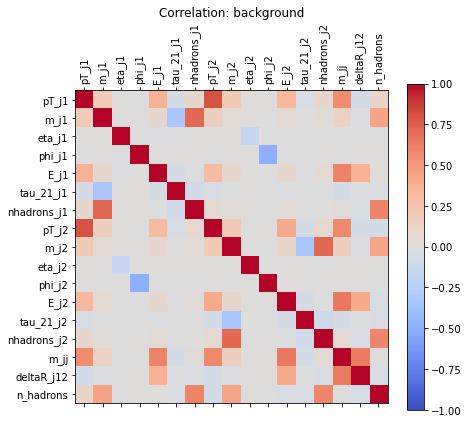

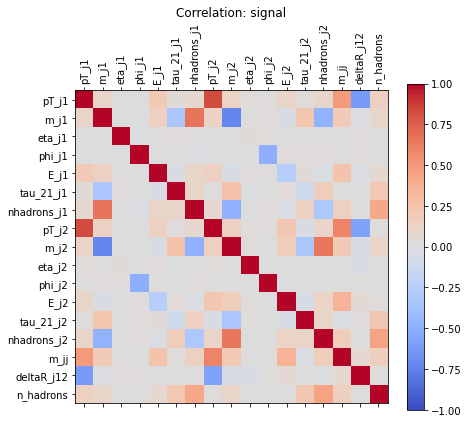

In [20]:
# We want to have the correlations for signal and background in separate dataframes
df_bkg = df[df['label']==0].drop('label', axis=1)
df_sig = df[df['label']==1].drop('label', axis=1)

df_bkg_corr = df_bkg.corr()
df_sig_corr = df_sig.corr()

# To graph the correlation map:
for name, corr in [('background', df_bkg_corr), ('signal', df_sig_corr)]:
    
    # Define the figure and size
    fig = plt.figure(figsize=[7,6])
    
    # Plot axis
    ax = fig.add_subplot(111)
    
    # Color bar for the mapping
    cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
    fig.colorbar(cax)
    
    # Axis
    ticks = np.arange(0,len(corr.columns),1)
    ax.set_xticks(ticks)
    plt.xticks(rotation=90)
    ax.set_yticks(ticks)
    ax.set_xticklabels(corr.columns)
    ax.set_yticklabels(corr.columns)
    
    # Title
    plt.title('Correlation: {}'.format(name))
    plt.show()

We can plot some of the relations that looks interesting to the project using the <code>bkg_sig_scatter</code> function:

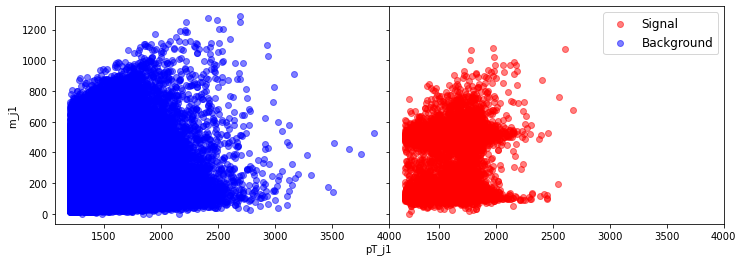

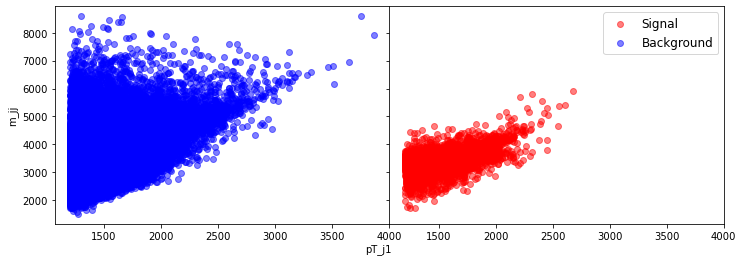

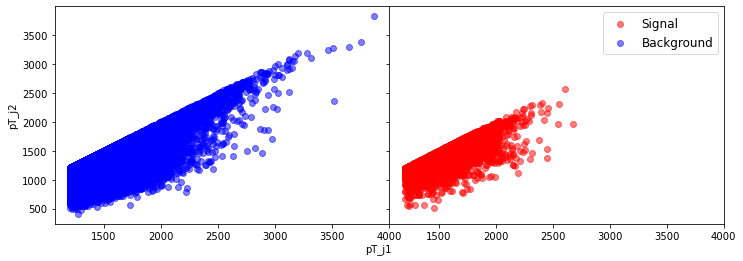

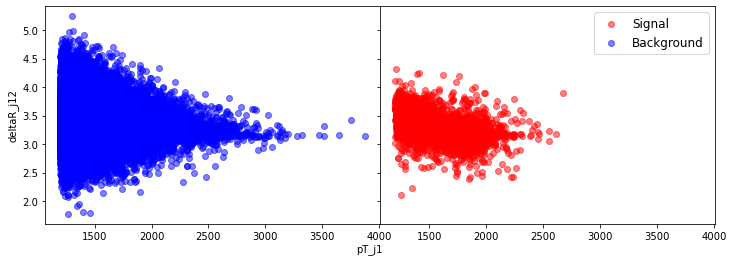

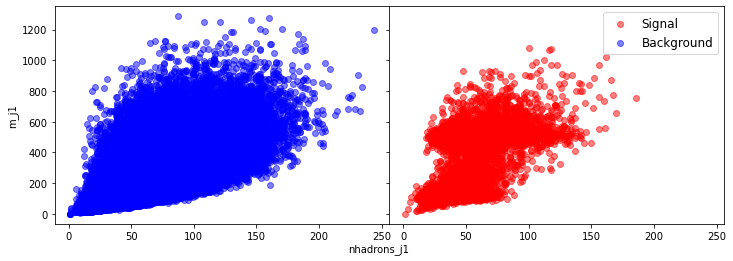

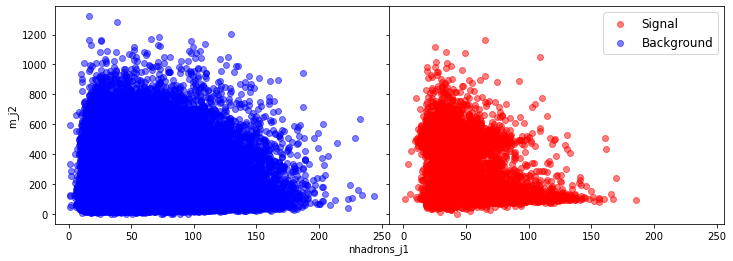

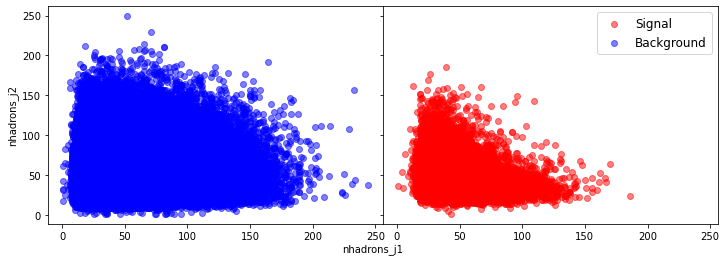

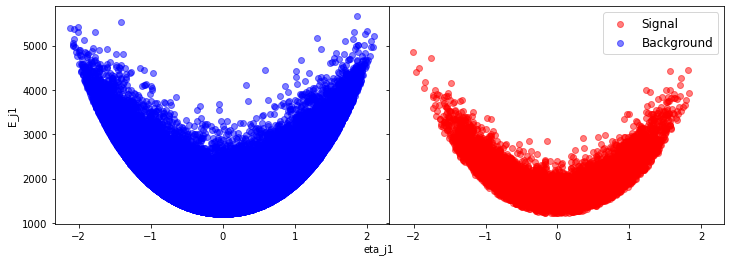

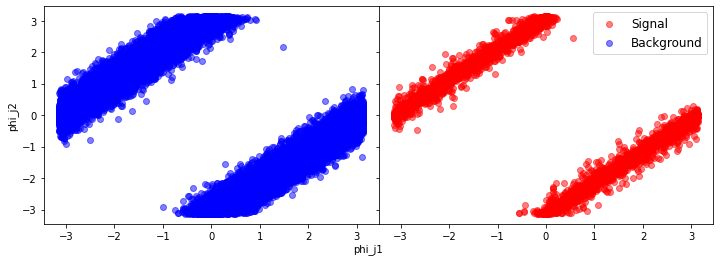

In [21]:
from benchtools.src.plotools import bkg_sig_scatter

relations = [('pT_j1', 'm_j1'), ('pT_j1', 'm_jj'), ('pT_j1', 'pT_j2'), ('pT_j1', 'deltaR_j12'), ('nhadrons_j1', 'm_j1'), ('nhadrons_j1', 'm_j2'),
             ('nhadrons_j1', 'nhadrons_j2'), ('eta_j1', 'E_j1'), ('phi_j1', 'phi_j2')]
for x,y in relations:
    bkg_sig_scatter(df, x, y)
    plt.show()

All the distributions and correlation plots are in [this notebook](2.0-all-distribution-correlation-plots.ipynb)

## BB1 dataset
For this dataset there is 0.08% of signal and the masses for the BSM particles are *Z'*, *X* and *Y* are 3.823 TeV, 732 GeV and 378 GeV, respectively.

We are going to run the exact same code as before from the clustering, but with the BB1 data:

In [22]:
# Calculating the variables
build_features("../../events_LHCO2020_BlackBox1.h5", 3, "data_exploration_BB1", 
               path_label='../../events_LHCO2020_BlackBox1.masterkey')

Part 1/3


100%|██████████| 51200/51200 [13:54<00:00, 61.34it/s]


Part 2/3


100%|██████████| 51200/51200 [16:21<00:00, 52.19it/s] 


Part 3/3


100%|██████████| 51200/51200 [15:28<00:00, 55.15it/s] 


Done


In [23]:
df = read_multifiles("data_exploration_BB1", 3)
df.head()

,pT_j1,m_j1,eta_j1,phi_j1,E_j1,tau_21_j1,nhadrons_j1,pT_j2,m_j2,eta_j2,phi_j2,E_j2,tau_21_j2,nhadrons_j2,m_jj,deltaR_j12,n_hadrons,label
0,1397.005228,170.225610,-0.765391,0.537239,1834.490410,0.543602,70,1347.988973,427.365520,0.225140,-2.740281,1446.853969,0.880080,82,3157.841212,3.423930,230.0,0.0
1,1273.332773,327.845663,0.354693,-0.951367,1393.391014,0.403889,77,1034.297905,106.489303,-0.364250,2.119474,1108.799742,0.927609,44,2488.262160,3.153878,156.0,0.0
2,1268.472197,72.622808,-1.055852,-0.319414,2045.001255,0.685529,21,1133.216562,456.691841,0.738184,2.727534,1526.179769,0.073868,54,3499.867409,3.535882,134.0,0.0
3,1414.022037,208.706758,-0.428495,2.622507,1559.858883,0.405329,81,1364.308129,60.057918,-0.242186,-0.992484,1405.798737,0.638481,39,2729.477504,3.619790,247.0,0.0
4,1220.274012,170.788218,-0.076185,-1.373332,1235.676617,0.466025,38,1210.723592,402.915624,-0.275398,1.633799,1319.927141,0.097154,34,2513.728451,3.013722,148.0,0.0


Checking that we have a good representation of the signal:

In [24]:
# The percentage of signal
nsignal = df[df['label']==1].shape[0]

print('The percentage of signal on this dataframe is: {:.3%}'.format(nsignal/(df.shape[0])))

The percentage of signal on this dataframe is: 0.082%


In [25]:
nsignal = df[df['label']==1].shape[0]
nbkg = df[df['label']==0].shape[0]
print(nsignal, nbkg, df.shape[0])

126 153474 153600


## Distributions

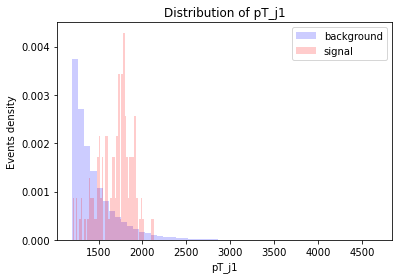

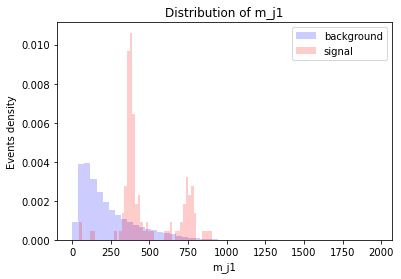

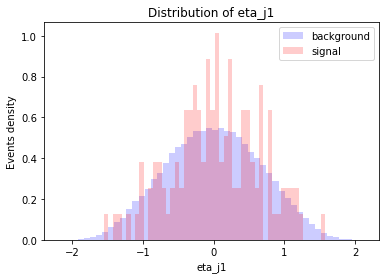

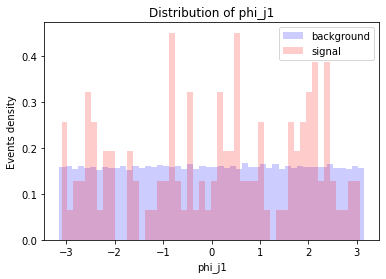

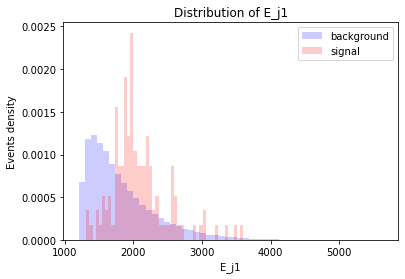

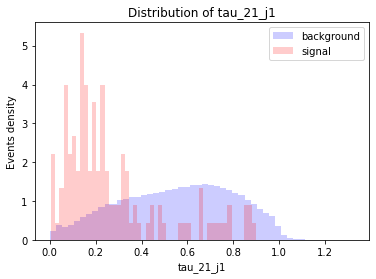

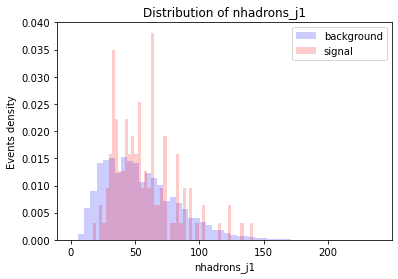

In [26]:
# Getting a list of the variable names
variables = df.columns.tolist()

for variable in variables[0:7]:
    bkg_sig_hist(df, variable=variable, label='label')
    plt.show()

The distributions for both signal and background look similar to the ones of the R&D dataset. However, since there is little signal, the signal plots aren't as clear on this dataset.

## Correlations
We want to see how the correlations are for this dataset, if they are similar to the R&D dataset:

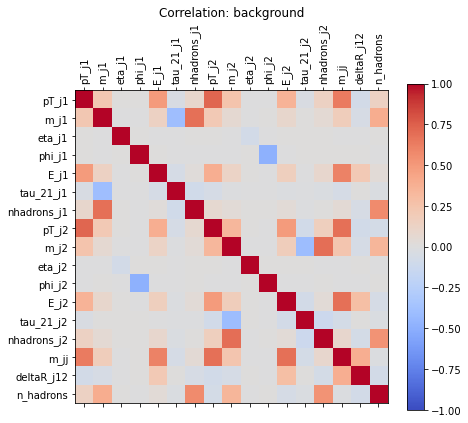

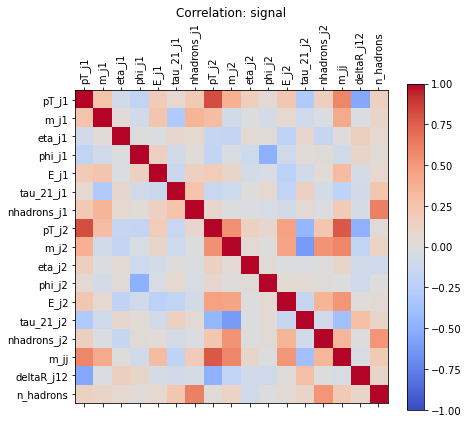

In [27]:
# We want to have the correlations for signal and background in separate dataframes
df_bkg = df[df['label']==0].drop('label', axis=1)
df_sig = df[df['label']==1].drop('label', axis=1)

df_bkg_corr = df_bkg.corr()
df_sig_corr = df_sig.corr()

# To graph the correlation map:
for name, corr in [('background', df_bkg_corr), ('signal', df_sig_corr)]:
    
    # Define the figure and size
    fig = plt.figure(figsize=[7,6])
    
    # Plot axis
    ax = fig.add_subplot(111)
    
    # Color bar for the mapping
    cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
    fig.colorbar(cax)
    
    # Axis
    ticks = np.arange(0,len(corr.columns),1)
    ax.set_xticks(ticks)
    plt.xticks(rotation=90)
    ax.set_yticks(ticks)
    ax.set_xticklabels(corr.columns)
    ax.set_yticklabels(corr.columns)
    
    # Title
    plt.title('Correlation: {}'.format(name))
    plt.show()

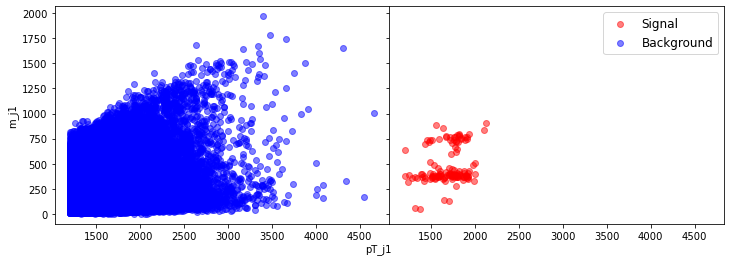

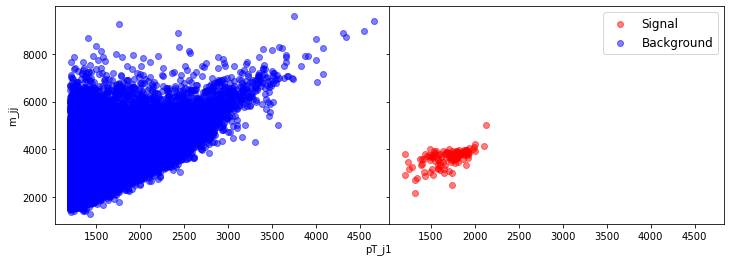

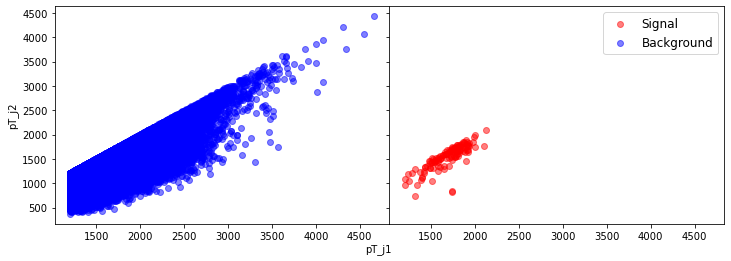

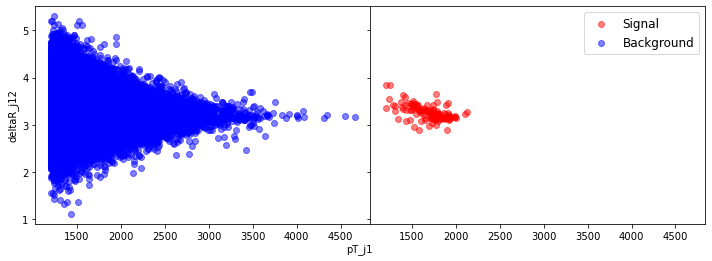

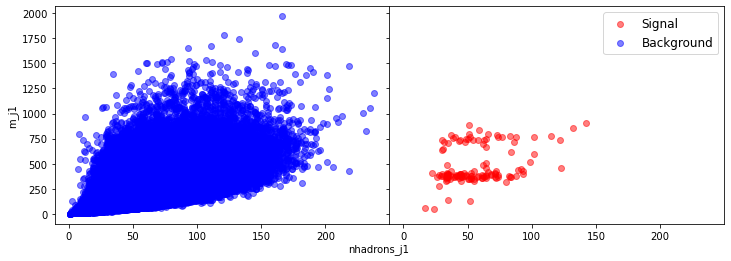

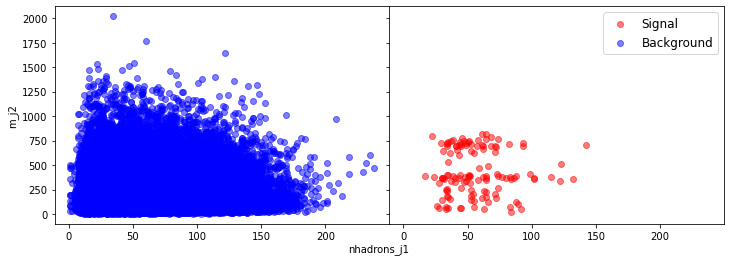

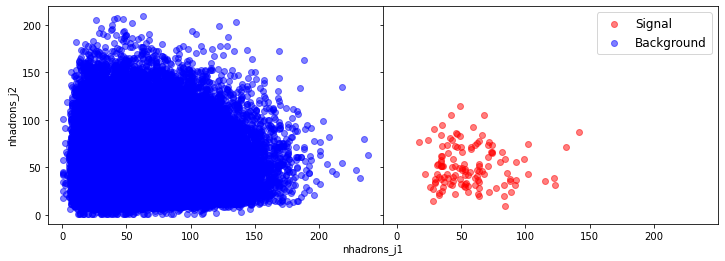

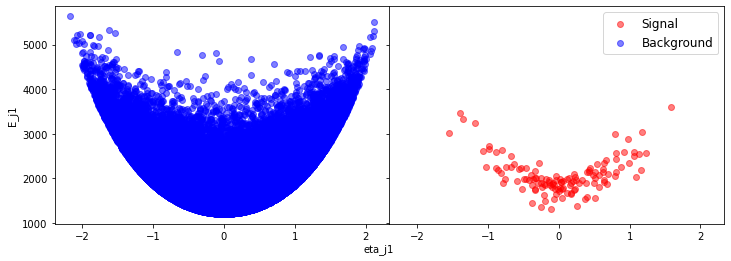

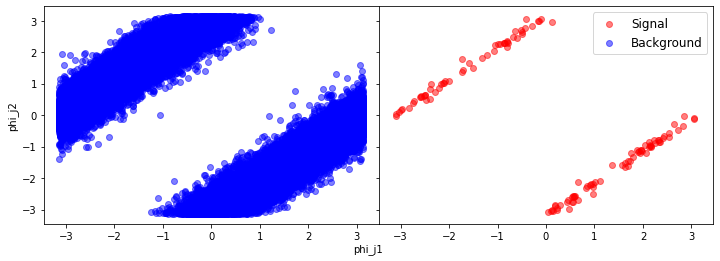

In [28]:
relations = [('pT_j1', 'm_j1'), ('pT_j1', 'm_jj'), ('pT_j1', 'pT_j2'), ('pT_j1', 'deltaR_j12'), ('nhadrons_j1', 'm_j1'), ('nhadrons_j1', 'm_j2'),
             ('nhadrons_j1', 'nhadrons_j2'), ('eta_j1', 'E_j1'), ('phi_j1', 'phi_j2')]
for x,y in relations:
    bkg_sig_scatter(df, x, y)
    plt.show()